# **Evaluate Retrieval Performance**

This notebook evaluates the **retrieval component** of our RAG system using synthetic questions with known ground-truth documents.

### Key Steps:
- **Load synthetic evaluation data** with grounded questions
- **Perform retrieval** using Azure AI Search
- **Evaluate performance** using standard Information Retrieval metrics
- **Analyze results** across different top-k values

### Why Retrieval Evaluation Matters in RAG:
The retrieval stage is often the **bottleneck** in RAG systems. If the correct documents aren't retrieved, even the best LLM cannot provide accurate answers. This evaluation helps us:
- Measure how often we find the right documents
- Understand how well we rank relevant documents
- Optimize search configurations for maximum recall

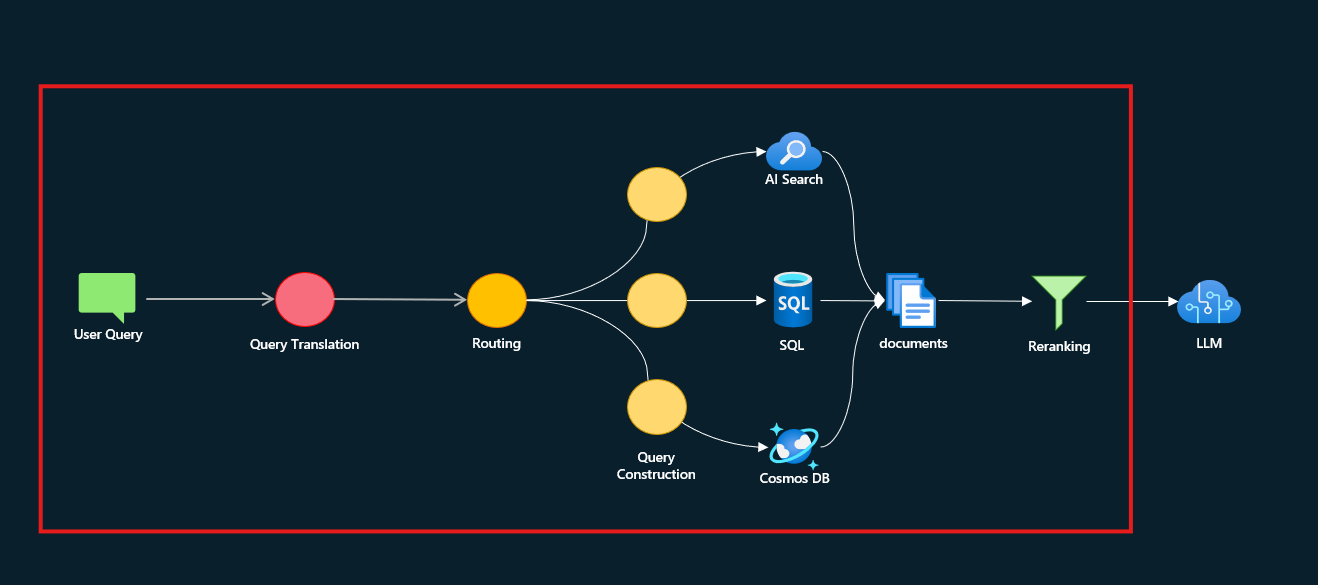

In [18]:
from IPython.display import Image, display
display(Image(filename='media/retrieval.png', width=1200))

In [1]:
import os
from dotenv import dotenv_values
from typing import List
from pydantic import BaseModel, Field

from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import VectorizableTextQuery

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

config = dotenv_values(".env")

aoai_endpoint = config["AOAI_ENDPOINT"]
aoai_key = config["AOAI_KEY"]
aoai_api_version = config["AOAI_API_VERSION"]
aoai_chat_model = config["chatModel"]
aoai_chat_model_mini = config["chatModel"]
aoai_embedding_model = config["embeddingModel"]
search_endpoint = config["SEARCH_ENDPOINT"]
search_key = config["SEARCH_KEY"]
search_credential = AzureKeyCredential(search_key)

## **Read Data**

In [2]:
fpath='data/synthetic_samples.csv'
df = pd.read_csv(fpath)
df = df[["synthetic_question", "chunk_id", "is_grounded", "domain", "difficulty", "tone", "question_length", "synthetic_question_embedding"]]
df = df[df["is_grounded"] == True]
df.head(1)

,synthetic_question,chunk_id,is_grounded,domain,difficulty,tone,question_length,synthetic_question_embedding
2,Vilka storlekar finns Summit Breeze Jacket til...,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,True,Related to Customer,Beginner,Angry,19,"[-0.034825511276721954, 0.021744225174188614, ..."


## **Retrieve Data**

In [3]:
from agents import Agent, Runner
from utils.llm import set_openai_config
set_openai_config()

class QuestionSchema(BaseModel):
    """
    Schema for the JSON response returned by the LLM.
    The 'queries' field is a list of synthetic questions.
    """
    queries: List[str] = Field(
        ...,
        description="A list of rewritten variations of the original question or sub-questions related to the original topic."
    )

async def rewrite_query(query):
    system = """You are an expert at converting user questions into search queries. \
    You have access to a search index of customer reviews and product specifications. \
    Given a user question, your task is to rewrite and break down the question into smaller multiple variations or sub-questions. \
    The idea is to cover a broader area of the document space to find more relevant product related documents. \
    example:
        Question: "Tell me about Product A"
        Output: "queries": ["what are the main features of Product A?", "Can you tell me some review regarding Product A", "Who have recently purchased Product A?"]

        Question: "How many features does product A have, and when was it released?"
        queries: "queries": ["Feature list of Product A", "When was product A released"]
            
    If there are acronyms or words you are not familiar with, do not try to rephrase them."""

    agent = Agent(
        name="query-analyzer",
        model=os.getenv("chatModelMiniFast"),
        instructions=system,
        output_type=QuestionSchema
    )

    try:
        response = await Runner.run(
            starting_agent=agent,
            input=query
        )
        return response.final_output.queries
    except Exception as e:
        print(e)

In [4]:
import asyncio

async def get_search_results(query, index, rewrite=False, k=1):
    if rewrite:
        try:
            # Optionally rewrite the query with an LLM
            rewritten_queries = await rewrite_query(query)

            # Quote the rewritten queries before joining them together using the query syntax
            formatted_queries = [f'"{rewritten_query}"' for rewritten_query in rewritten_queries]

            # Use the OR operator to join rewritten queries together
            # https://learn.microsoft.com/azure/search/query-lucene-syntax#bkmk_boolean
            search_text = " | ".join(formatted_queries) # " OR ".join(formatted_queries)
            semantic_query = " ".join(rewritten_queries)
        except Exception as e:
            print(e)
    else:
        search_text = query
        formatted_queries = [query]
        semantic_query = query

    # Define synchronous search function to run in thread pool
    def _sync_search():
        try:
            search_client = SearchClient(endpoint=search_endpoint, index_name=index, credential=search_credential)
            results = search_client.search(
                search_text=search_text,
                vector_queries=[
                    VectorizableTextQuery(
                        text=formatted_query,
                        k_nearest_neighbors=50,
                        fields="text_vector"
                    )
                    for formatted_query in formatted_queries
                ],
                # search_mode="any",
                search_fields=["chunk"],
                query_type="semantic",
                semantic_query=semantic_query,
                semantic_configuration_name="product-customer-vector-semantic-configuration",
                top=k  # use the parameter k here
            )

            # Format search results
            data = []
            for result in results:
                data.append({
                    "chunk_id": result["chunk_id"],
                    "document_title": result["title"],
                    "text_vector": result["text_vector"],
                    "search_score": result["@search.score"],
                    "reranker_score": result["@search.reranker_score"],
                })
            return data
        except Exception as e:
            print(e)
            return None
    
    # Run the synchronous search in a thread pool to avoid blocking
    return await asyncio.to_thread(_sync_search)

**For every synthetic question, perform a search**

In [5]:
from tqdm.asyncio import tqdm_asyncio
import asyncio

index_name = os.getenv("SEARCH_INDEX_NAME")

# Create semaphore to limit concurrent requests (adjust based on your search tier)
MAX_CONCURRENT_REQUESTS = 5
semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)

async def process_single_query(row, index_name):
    """Process a single query and return prediction dict"""
    async with semaphore:  # Limit concurrent requests
        question = row["synthetic_question"]
        chunk_id = row["chunk_id"]
        
        results = await get_search_results(
            query=question,
            index=index_name,
            rewrite=False,
            k=5
        )
        
        return {
            "question": question,
            "chunk_id_ground_truth": chunk_id,
            "results": results
        }

# Create tasks for all queries
tasks = []
for _, row in df.iterrows():
    task = process_single_query(row, index_name)
    tasks.append(task)

# Run all tasks concurrently with progress bar
retrievals = await tqdm_asyncio.gather(*tasks, desc="Retrieving documents")

Retrieving documents: 100%|██████████| 88/88 [00:11<00:00,  7.94it/s]


## **Evaluate retrieval**

### **Retrieval Metrics**

We use standard **Information Retrieval (IR) metrics** to evaluate retrieval performance:

**Hit Rate @ k**  
Percentage of queries where the correct document appears in top-k results.  
*Example: Hit Rate @ 3 = 0.92 means 92% of queries find the right doc in top 3.*

**MRR (Mean Reciprocal Rank)**  
Average of `1/rank` where rank is the position of the correct document.  
*Example: Doc at position 1 = score 1.0, position 3 = score 0.33.*

**Why these metrics?**  
In RAG, we prioritize **recall over precision**—missing the right doc means the LLM can't answer correctly. Retrieving a few extra docs is acceptable since LLMs filter noise well. This is why we use k=3 or k=5 instead of k=1.

In [7]:
def evaluate_retrieval(retrievals, k):
    """
    Evaluate retrieval using standard IR metrics: Hit Rate and MRR.
    
    Args:
        retrievals: List of retrieval dicts with 'chunk_id_ground_truth' and 'results'
        k: Number of top results to consider
        
    Returns:
        dict: Metrics including hit_rate, mrr, and counts
    """
    hits = 0
    reciprocal_ranks = []
    
    for pred in retrievals:
        true_chunk = pred["chunk_id_ground_truth"].split("_synthetic")[0]
        results = pred["results"] if pred["results"] is not None else []
        retrieved_ids = [res["chunk_id"] for res in results[:k]]
        
        if true_chunk in retrieved_ids:
            hits += 1
            rank = retrieved_ids.index(true_chunk) + 1
            reciprocal_ranks.append(1.0 / rank)
        else:
            reciprocal_ranks.append(0.0)
    
    total = len(retrievals)
    hit_rate = hits / total if total > 0 else 0.0
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0
    
    print(f"\n{'='*50}")
    print(f"Retrieval Evaluation @ k={k}")
    print(f"{'='*50}")
    print(f"Hit Rate@{k}:  {hit_rate:.4f} ({hit_rate*100:.2f}%)")
    print(f"MRR:           {mrr:.4f}")
    print(f"Hits:          {hits}/{total}")
    print(f"{'='*50}\n")
    
    return {
        "k": k,
        "hit_rate": hit_rate,
        "mrr": mrr,
        "hits": hits,
        "total": total
    }

**Compute metrics**

In [8]:
# --- Evaluate Retrieval for k=1, k=3, and k=5 ---
metrics_k1 = evaluate_retrieval(retrievals, k=1)
metrics_k3 = evaluate_retrieval(retrievals, k=3)
metrics_k5 = evaluate_retrieval(retrievals, k=5)


Retrieval Evaluation @ k=1
Hit Rate@1:  0.4773 (47.73%)
MRR:           0.4773
Hits:          42/88


Retrieval Evaluation @ k=3
Hit Rate@3:  0.8750 (87.50%)
MRR:           0.6591
Hits:          77/88


Retrieval Evaluation @ k=5
Hit Rate@5:  0.9205 (92.05%)
MRR:           0.6699
Hits:          81/88



**Display metrics**

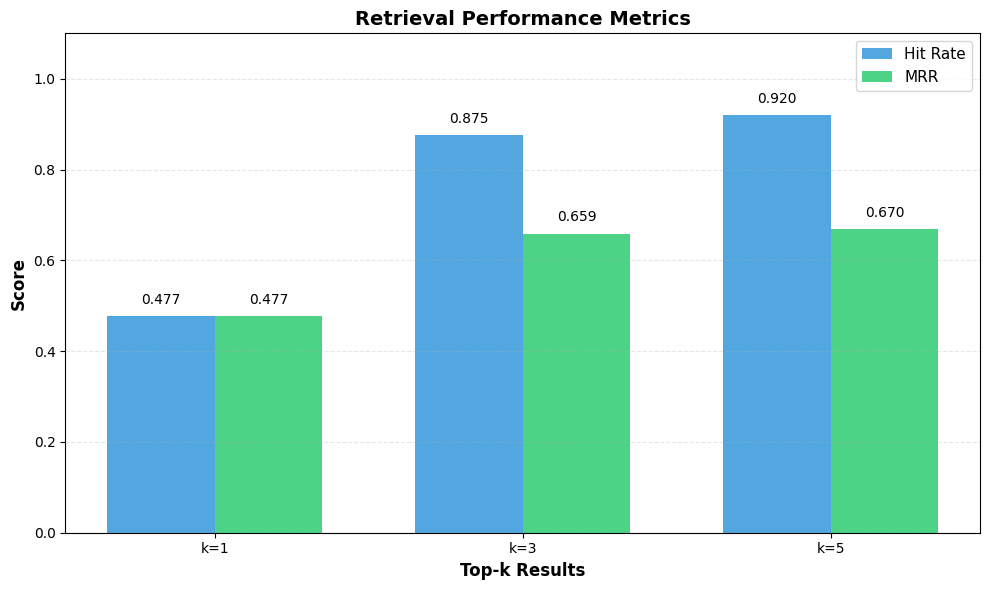

In [9]:
def plot_retrieval_metrics(metrics_k1, metrics_k3, metrics_k5):
    """Plot Hit Rate and MRR across different k values."""
    k_values = [metrics_k1["k"], metrics_k3["k"], metrics_k5["k"]]
    hit_rates = [metrics_k1["hit_rate"], metrics_k3["hit_rate"], metrics_k5["hit_rate"]]
    mrrs = [metrics_k1["mrr"], metrics_k3["mrr"], metrics_k5["mrr"]]
    
    _, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(k_values))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, hit_rates, width, label='Hit Rate', color='#3498db', alpha=0.85)
    bars2 = ax.bar(x + width/2, mrrs, width, label='MRR', color='#2ecc71', alpha=0.85)
    
    ax.set_xlabel('Top-k Results', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Retrieval Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'k={k}' for k in k_values])
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_retrieval_metrics(metrics_k1, metrics_k3, metrics_k5)

### **Interpreting the Results**

#### **What Good Metrics Look Like:**
- **Hit Rate @ 1 > 0.70**: Most queries find the right doc as the top result ✅
- **Hit Rate @ 3 > 0.85**: Nearly all queries find the right doc in top 3 ✅
- **Hit Rate @ 5 > 0.90**: Excellent - very few misses ✅
- **MRR > 0.80**: Relevant docs are consistently ranked high ✅

#### **If Metrics Are Low:**
Consider these optimization strategies:
1. **Improve chunking strategy** - Chunks may be too small/large
2. **Enhance metadata** - Add more searchable fields
3. **Increase value of k** - Trade precision for recall
4. **Query rewrite strategy** - Trade precision for recall
5. **Generate more diverse synthetic questions** - Cover edge cases better

#### **Next Steps:**
Once retrieval performs well (Hit Rate @ 5 > 0.85), move to:
- **LLM Evaluation** (notebook `05_evaluate_llm.ipynb`) - Test if LLM correctly uses retrieved documents
- **End-to-end RAG Testing** - Evaluate the complete system

In [10]:
# import os
# import openai
# import dotenv

# dotenv.load_dotenv()

# endpoint = os.environ.get("AOAI_ENDPOINT")
# api_key = os.environ.get("AOAI_KEY")
# deployment = os.environ.get("chatModel")

# client = openai.AzureOpenAI(
#     azure_endpoint=endpoint,
#     api_key=api_key,
#     api_version="2024-10-21",
# )

# completion = client.chat.completions.create(
#     model=deployment,
#     messages=[
#         {
#             "role": "user",
#             "content": "What's the price for the TrailMaster X4?",
#         },
#     ],
#     extra_body={
#         "data_sources":[
#             {
#                 "type": "azure_search",
#                 "parameters": {
#                     "endpoint": os.environ["SEARCH_ENDPOINT"],
#                     "index_name": os.environ["SEARCH_INDEX_NAME"],
#                     "authentication": {
#                         "type": "api_key",
#                         "key": os.environ["SEARCH_KEY"],
#                     }
#                 }
#             }
#         ],
#     }
# )

# print(f"{completion.choices[0].message.role}: {completion.choices[0].message.content}")

In [11]:
# for source in completion.choices[0].message.context["citations"]:
#     print(source["title"])

# **APPENDIX**

## **1. Scoring Metrics**

##### **Reranker Score (`search.reranker_score`)**

| Score | Meaning |
|-------|---------|
| **4.0** | Highly relevant – the document fully answers the question (may include extra text). |
| **3.0** | Relevant – answers the question but lacks some details. |
| **2.0** | Somewhat relevant – partially answers the question or only covers some aspects. |
| **1.0** | Minimally relevant – only a small part of the question is addressed. |
| **0.0** | Irrelevant. |

##### **BM25 Score (`search.score`)**

- **Range:** Unbounded.
- **Interpretation:** A higher BM25 score indicates greater relevance, as it measures document-query matching based on term frequency and inverse document frequency.


## **2. Understanding Retrieval Metrics in RAG Systems**

In a RAG (Retrieval-Augmented Generation) system, we evaluate retrieval using **information retrieval (IR) metrics**, not traditional classification metrics.

#### **Key Metrics**

**1. Hit Rate @ k (Recall @ k)**
- **Definition**: Percentage of queries where the correct document appears in the top-k results
- **Formula**: `(# of queries with correct doc in top-k) / (total queries)`
- **Interpretation**: 
  - Hit Rate @ 1 = 0.85 → 85% of queries get the RIGHT chunk as #1 result
  - Hit Rate @ 3 = 0.92 → 92% of queries get the RIGHT chunk in top 3
  - Hit Rate @ 5 = 0.95 → 95% of queries get the RIGHT chunk in top 5


**Hit Rate @ k**  
Percentage of queries where the correct document appears in top-k results.  
*Example: Hit Rate @ 3 = 0.92 means 92% of queries find the right doc in top 3.*

**2. Mean Reciprocal Rank (MRR)**
- **Definition**: Average of 1/rank for the first correct document
- **Formula**: `mean(1/rank)` where rank is the position of the correct document
- **Interpretation**: Rewards ranking the correct document higher
  - Document at position 1 → score = 1.0
  - Document at position 3 → score = 0.33
  - Document at position 5 → score = 0.20

#### **The Precision vs. Recall Trade-off in RAG**

In RAG systems, we typically **prioritize recall over precision** because:

✅ **High Recall is Critical**
- We MUST retrieve all relevant documents
- Missing the relevant document = LLM cannot answer correctly
- This is the "weak link" in the RAG pipeline

✅ **Lower Precision is Acceptable**
- Retrieving some irrelevant documents alongside relevant ones is OK
- Modern LLMs are good at finding relevant information among noise
- The LLM acts as a "filter" for the retrieved documents

**Trade-off Strategy:**
```
Retrieval: Cast a wide net (high recall, acceptable precision)
    ↓
LLM: Extract relevant information (high precision)
```

This is why we often use **k=3 or k=5** instead of k=1 - we're willing to retrieve a few extra documents to ensure we don't miss the relevant one.

#### **Why Not Traditional Classification Metrics?**

Traditional metrics like precision, recall, and F1 from classification are **not appropriate** here because:
- All our queries have a known correct answer (all `y_true = 1`)
- We're not doing binary classification; we're ranking documents
- Hit Rate and MRR are the standard metrics for retrieval evaluation in IR literature